In [1]:
# Board Game Analytics Intro
# Matt Spencer - DataBard
# www.databard.blog
# 12/15/2017
library(dplyr) 
library(ggplot2)
library(splitstackshape)
library(VennDiagram)
library(treemap)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Loading required package: data.table

Attaching package: ‘data.table’

The following objects are masked from ‘package:dplyr’:

    between, last

Loading required package: grid
Loading required package: futile.logger


In [2]:
games <- read.csv('../data/bgg_db_2017_04.csv') %>%
    filter(! (min_players == '0' & max_players == '0' ) )
# Note that there are several entries as "games" that are actually catch-alls
# for some game categories, such as "Traditional Card Games". Additionally,
# there are several games that are poorly documented in some respects, 
# bringing the curation of the present values into question. To address both
# of these issues, I removed all games that had both a min_players and 
# max_players of 0, as this seems to have covered most of it, only removing 
# 10 games from the list.

# However, also note that there are situations where min_players is a 
# realistic number, but max_players is 0. Manual investigation reveals that
# this typically indicates that the only supported number of players is the
# min_player value.
           
# Also note that games that have no player limit often have arbitrarily large
# values for max_players, like 99 or 999, which is why I stopped my histogram
# below at players<=10

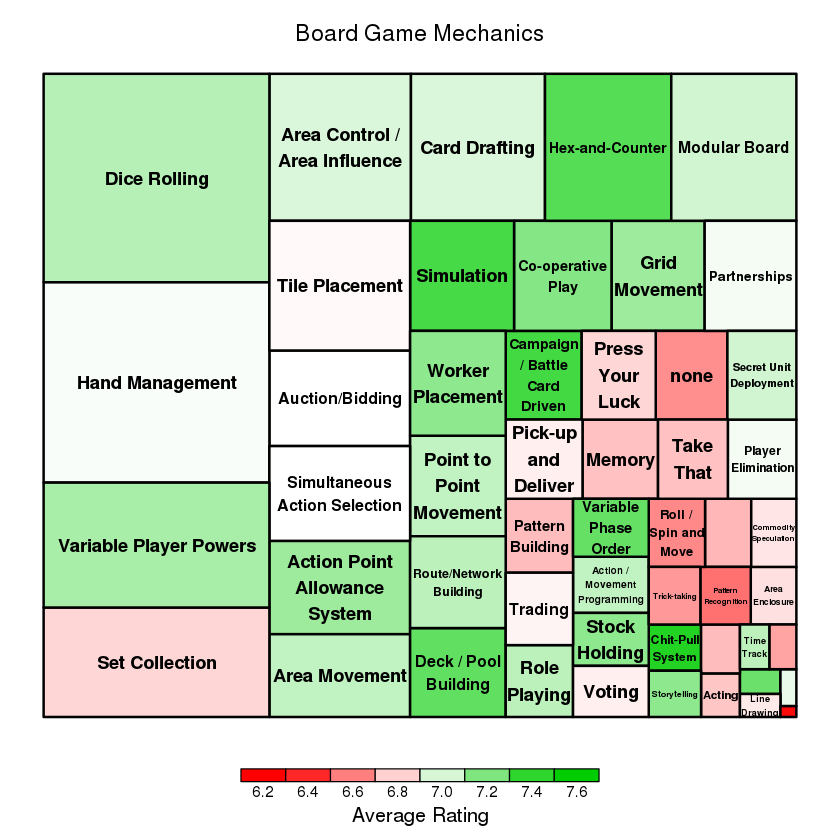

In [3]:
# Right now all mechanics for a game are listed in a single comma-separated 
# field. Expand these out so there are multiple rows per game, each with a
# single mechanic.
games$mechanic <- as.character(games$mechanic)
games.mechexpand <- cSplit(games, splitCols = "mechanic", direction = "long")

# Now calculate the mean average rating for each mechanic
# and the number of games with that mechanic.
mech.info <- games.mechexpand %>%
    group_by(mechanic) %>%
    mutate(count = length(mechanic), Average_Rating = mean(avg_rating)) %>%
    select(mechanic, count, Average_Rating) %>%
    unique()

# Plot a TreeMap using this data
#jpeg(filename = "Mechanic.Treemap.jpeg", width = 6, height = 6, units = 'in', res = 200)
treemap(mech.info, index = "mechanic", vSize = "count", vColor = "Average_Rating", type = 'value', 
        title = 'Board Game Mechanics', title.legend = 'Average Rating',
        palette = c('#ff0000','#ffffff','#00cc00'), range = c(6.2,7.6), mapping = c(6.3,7.5))
#dev.off()

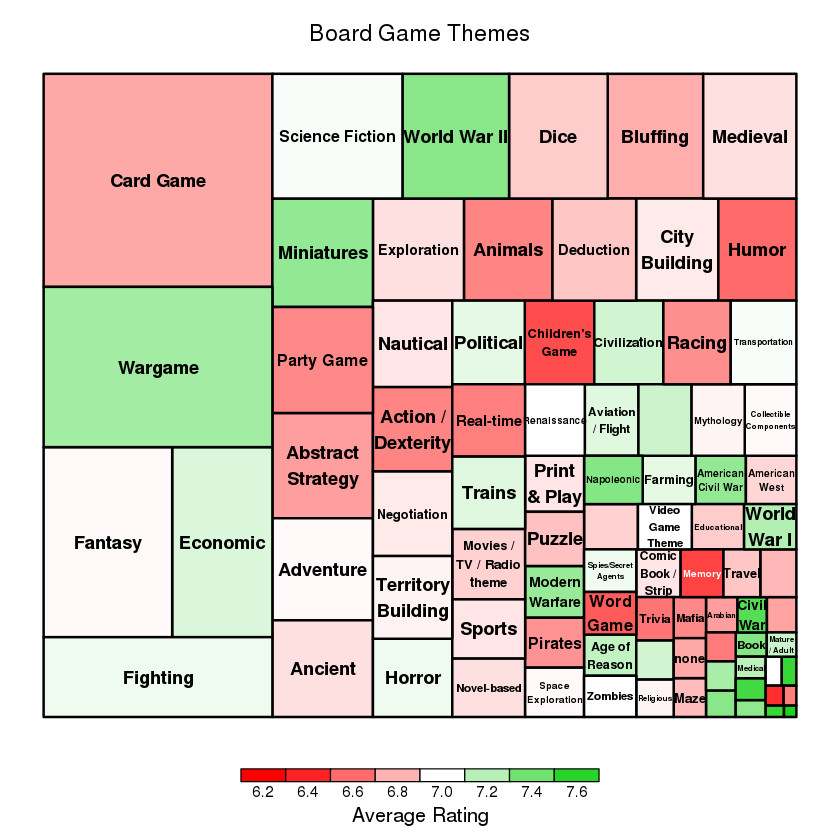

In [90]:
# Similarly to Mechanics, Categories are also in a comma-separated field.
# So we can address them in a similar fashion.
games$category <- as.character(games$category)
games.catexpand <- cSplit(games, splitCols = "category", direction = "long")

# Calculate mean average rating
cat.info <- games.catexpand %>%
    group_by(category) %>%
    mutate(count = length(category), Average_Rating = mean(avg_rating)) %>%
    select(category, count, Average_Rating) %>%
    unique()

# Generate TreeMap
#jpeg(filename = "Category.Treemap.jpeg", width = 6, height = 6, units = 'in', res = 200)
treemap(cat.info, index = "category",vSize = "count", vColor = "Average_Rating", type = 'value', 
        title = 'Board Game Themes', title.legend = 'Average Rating',
        palette = c('#ff0000','#ffffff','#00cc00'), range = c(6.3,7.7), mapping = c(6.3,7.7))
#dev.off()

In [11]:
# Identify the games that have at least one of the chosen mechanics
select.mechs <- c('Deck / Pool Building', 'Variable Player Powers', 'Modular Board', 'Role Playing', 'Co-operative Play')
select.gamelist <- games.mechexpand %>% 
    filter(mechanic %in% select.mechs) %>% 
    select(names, mechanic, category) %>%
    group_by(names) %>%
    unique() %>%
    mutate(repetitive = length(names)) %>%
    select(names, repetitive) %>%
    unique() 
select.games <- merge(games, select.gamelist, by = 'names')

In [55]:
# Count just how many of the chosen mechanics are present in the games
# This lets us find games with many of the mechanics
mech.count <- games.mechexpand %>% 
    filter(mechanic %in% select.mechs) %>% 
    select(names, mechanic, category) %>%
    group_by(names) %>%
    unique() %>%
    mutate(num.mechs = length(names)) %>%
    select(names, num.mechs) %>%
    unique() 

# Which games have the most selected mechanics?
mech.count %>%
    arrange(desc(num.mechs)) %>%
    head(10)

# Convert the number of mechanics to a factor - 
# this will make plotting it easier in a moment.
mech.count$num.mechs <- factor(mech.count$num.mechs, levels = c('5','4','3','2','1'))

names,num.mechs
Mage Knight Board Game,5
Mansions of Madness: Second Edition,4
Arkham Horror: The Card Game,4
Arkham Horror,4
Shadows of Brimstone: City of the Ancients,4
Betrayal at House on the Hill,4
Shadows of Brimstone: Swamps of Death,4
Dungeons & Dragons: Wrath of Ashardalon Board Game,4
Dungeons & Dragons: Castle Ravenloft Board Game,4
Pathfinder Adventure Card Game: Skull & Shackles ? Base Set,4


In [78]:
# These functions help convert a value for minimum players
# and maximum players to the list of all possible number of
# players that can play the game. Note that this assumes 
# that a game can always be played with any number of 
# players between the min and max, which isn't always true.
get.numlist <- function(minval, maxval) {
    if (minval == 0 && maxval == 0) return('')
    if (maxval == 0) return(minval)
    if (minval == 0) minval <- 1
    numlist <- c()
    for (i in minval:maxval) {
        numlist <- c(numlist, i)
    }
    paste(numlist, collapse = ',')
}
        
expand.range <- function(min, max) {
    sapply(1:length(min), function(x) get.numlist(as.numeric(min[x]), as.numeric(max[x])))
}

In [79]:
# Similar to the Mechanic and Category expansions above, here
# we expand the data frame to have one row for every number of 
# players that can play each game.
games.plyrexpand <- games %>%
    mutate(players = expand.range(min_players, max_players)) %>%
    cSplit(splitCols = "players", direction = "long") %>%
    filter(players <= 10) %>%
    mutate(player.cat = factor(players))

# Same thing, but only using the games that have at least one
# of the chosen mechanics.
select.games.plyrexpand <- select.games %>%
    mutate(players = expand_range(min_players, max_players)) %>%
    cSplit(splitCols = "players", direction = "long") %>%
    filter(players <= 10) %>%
    mutate(player.cat = factor(players))

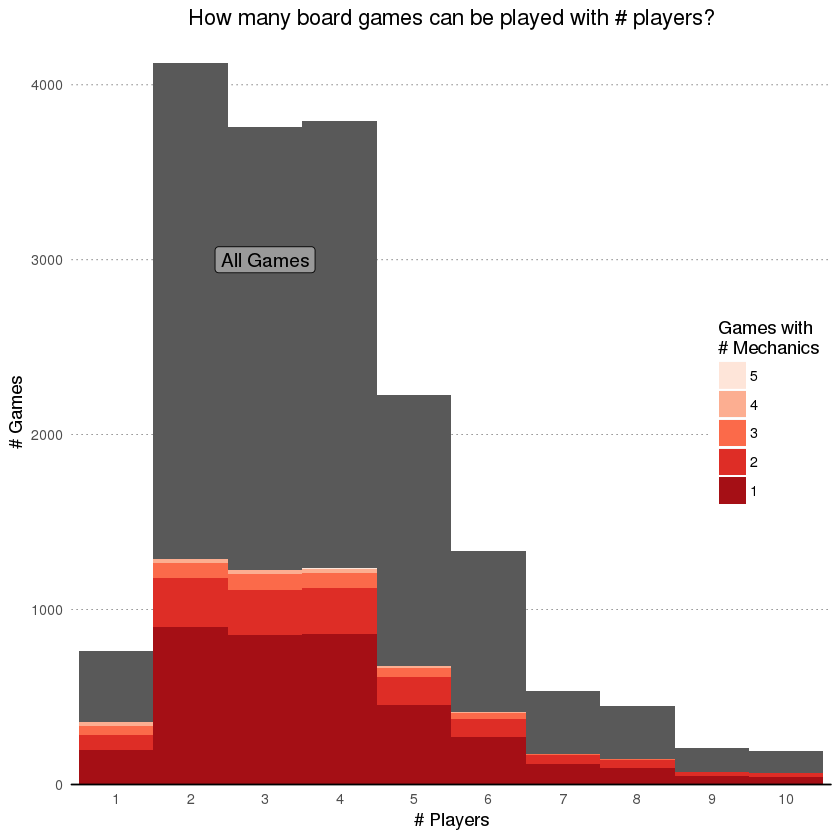

In [82]:
# Histogram that will compare the number of games that 
# can be played with certain numbers of players. Compare
# the distribution of the colored area representing the 
# selected games to the gray area representing all games.
plot <- select.games.plyrexpand %>% 
    select(names, player.cat) %>%
    merge(mech.count) %>%
    ggplot(aes(x = player.cat)) +
           ggtitle("How many board games can be played with # players?") +
           geom_bar(data = games.plyrexpand, width = 1) +
           geom_label(data = data.frame(), aes(x = '3', y = 3000, label = 'All Games'), size = 4, fill = 'gray60') +
           geom_bar(aes(fill = num.mechs), width = 1) +
           scale_fill_brewer(palette = 'Reds') +
           labs(x = '# Players', y = '# Games', fill = 'Games with\n# Mechanics') +
           scale_y_continuous(limits = c(0,4250), expand = c(0, 0)) +
           theme(
               plot.title = element_text(hjust = 0.5),
               
               panel.background = element_rect(fill = 'white'),
               panel.grid.major.x = element_blank(),
               panel.grid.major.y = element_line(colour = "gray20", size = 0.2, linetype = 'dotted'),
               axis.ticks = element_blank(),
               axis.line.x = element_line(color = "black", size = 0.5),
               
               legend.justification = c(1,0.5), legend.position = c(1,0.5)
               )
plot
#ggsave(file='PlayerDistribution.jpeg', plot, width = 8, height = 5, dpi = 300)